In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
import numpy as np
from scipy.interpolate import interp1d
from orbit_class import Orbit
import misc_utils as mu   
import ifs_noise_model as snr_ifs
import imaging_noise_model as snr_im
import juneper_model as hpm  
import coolTLUSTY_model as cpm
import simulate_data as simdata

/Users/blacy/EGPSemesterProject/GitHubFiles/direct-imaging-sims/WFIRST_SIM/misc_utils.py:162: RuntimeWarning: divide by zero encountered in true_divide
  tau_PSF = interp1d(rlamD,coreThruput/occTrans,fill_value=0.0,bounds_error=False)


In [19]:
def alpha_tsnr_plot(params,orbit,wavelengths,snr,cbar=True):
    sep,phi,wa=params['sep'], params['phi'], params['wa'] 
    texps = []
    alphas = []
    for alpha in np.linspace(0.0,180.0,1000):
        alphas.append(alpha)    
        alpha_r = alpha*np.pi/180.0 # phase angle in radians
        pfunc = mu.avg_empirical # type of phase function to use
        simdata.change_alpha(orbit, params, alpha_r, pfunc) # updates params['sep'], params['phi'], params['wa']    
        wl_texps = snr_ifs.calc_texp(snr,wavelengths,params)
        wl_texps = wl_texps/60.0/60.0
        mask = np.where(wl_texps < 0.0)[0]
        subvalue = 10000000.0
        for k in mask:
            wl_texps[k] = subvalue
        texps.append(wl_texps)
    #mask out the negative texps as super high
    texps = np.array(texps)
    zz = np.array(texps) 
    xx, yy = np.meshgrid(wavelengths, alphas)
    minorLocator = ticker.AutoMinorLocator()
    pcm = plt.pcolor(xx, yy, zz,
                       norm=colors.LogNorm(vmin=1.0,vmax=10000000.0),
                       cmap=mu.CMAP2, rasterized=True)
    plt.xlabel('Wavelength ($\mu$m)',fontsize=17)
    plt.ylabel('Phase Angle, $\\alpha$',fontsize=17)
    if cbar:
        cb = plt.colorbar(pcm, extend='max',orientation='horizontal')
        cb.set_label('Exposure Time to reach SNR = 5 (hours)',fontsize=17)

    params['sep'], params['phi'], params['wa'] = sep, phi, wa        
        
        
def rp_tsnr_plot(params,wavelengths,snr,cbar=True):
    rplanet = params['rp']
    texps = []
    radii = np.linspace(0.1,2.0,1000)
    for rp in radii:
        params.update({'rp':rp})
        wl_texps = snr_ifs.calc_texp(snr,wavelengths,params)
        wl_texps = wl_texps/60.0/60.0
        mask = np.where(wl_texps < 0.0)[0]
        subvalue = 10000000.0
        for k in mask:
            wl_texps[k] = subvalue
        texps.append(wl_texps)
    #mask out the negative texps as super high
    texps = np.array(texps)
    zz = np.array(texps) 
    xx, yy = np.meshgrid(wavelengths, radii)
    minorLocator = ticker.AutoMinorLocator()
    pcm = plt.pcolor(xx, yy, zz,
                       norm=colors.LogNorm(vmin=1.0,vmax=10000000.0),
                       cmap=mu.CMAP2, rasterized=True )
    if cbar:
        cb = plt.colorbar(pcm, extend='max',orientation='horizontal')
        cb.set_label('Exposure Time to reach SNR = 5 (hours)',fontsize=17)
    plt.xlabel('Wavelength ($\mu$m)',fontsize=17)
    plt.ylabel('Planet Radius (R$_{jup}$)',fontsize=17)

    params['rp'] = rplanet
    

Initiate dictionaries with planet-star parameters and coronagraph/telescope/detector parameters, lets make one for ups Andromedae d and one for HD 219134 h 

In [82]:
upsAnd_d = {}                  
upsAnd_d.update({'d_obs':13.47}) # distance to the observer in parsecs
M = 4.1 - 5.0*np.log10(upsAnd_d['d_obs']/10.0)
upsAnd_d.update({'Mstar':M})   # absolute stellar V-band magnitude apparent = 4.1
upsAnd_d.update({'Nez':1.0})     # exozodi level
stellartype = 'f5v'              # stellar type
stellar_mass = 1.27               # stellar mass in units of solar mass 
                                 # this is only used in orbit object, not really relevant for SNR calculations
stellar_spec = 'AuxiliaryData/'+stellartype+'.dat' # imports Hubble 
ref_wl, ref_flambda = np.loadtxt(stellar_spec, unpack=True, usecols=(0,1))
fstar_lambda = interp1d(ref_wl,ref_flambda)  # specific flux density W / m^2 / micron, for zero mag star
upsAnd_d.update({'fstar_lambda':fstar_lambda}) # a function which returns 
                                             # specific flux density for any wavelength
upsAnd_d.update({'rp':1.0})      # planet radius in Jupiter radii
upsAnd_d.update({'chromo':1.0,'meth':1.0}) # short wavelength (chromophore) and long wavelength (methane)
                                           # weightings for linear combination of Jupiter and Neptune 
upsAnd_d.update({'Ag':hpm.juneper_Agfunc(upsAnd_d['chromo'],upsAnd_d['meth'])}) 
a = 2.53            # semimajor axis (in au)
ecc = 0.267         # eccentricity
inc = 90.0          # inclination (degrees)
ome = 269.7         # longitude of ascending node (degrees)
tp = 0.0            # epoch of perihelion passage (julian date) 13937.73
argperi = 180.0     # argument of perihelion (degrees)   ???? 
upsAnd_d_orbit_pars = np.array([ecc,inc,ome,tp,a,argperi,
                       stellar_mass,upsAnd_d['rp'],upsAnd_d['d_obs']])
upsAnd_d_orbit = Orbit(upsAnd_d_orbit_pars) 
alpha = 75.0*np.pi/180.0 # phase angle in radians
pfunc = mu.avg_empirical # type of phase function to use
simdata.change_alpha(upsAnd_d_orbit, upsAnd_d, alpha, pfunc) # updates params['sep'], params['phi'], params['wa']
upsAnd_d.update(mu.cbe_spc_pars)

# ---------------------------------------------------------------

HD_h = {}                  
HD_h.update({'d_obs':6.55})  # distance to the observer in parsecs
M = 5.57 - 5.0*np.log10(HD_h['d_obs']/10.0)
HD_h.update({'Mstar':M})   # absolute stellar V-band magnitude 
HD_h.update({'Nez':1.0})     # exozodi level
stellartype = 'k5v'              # stellar type
stellar_mass = 0.794               # stellar mass in units of solar mass 
                                 # this is only used in orbit object, not really relevant for SNR calculations
stellar_spec = 'AuxiliaryData/'+stellartype+'.dat' # imports Hubble 
ref_wl, ref_flambda = np.loadtxt(stellar_spec, unpack=True, usecols=(0,1))
fstar_lambda = interp1d(ref_wl,ref_flambda)  # specific flux density W / m^2 / micron, for zero mag star
HD_h.update({'fstar_lambda':fstar_lambda}) # a function which returns 
                                             # specific flux density for any wavelength
HD_h.update({'rp':0.83294})      # planet radius in Jupiter radii
HD_h.update({'chromo':1.0,'meth':1.0}) # short wavelength (chromophore) and long wavelength (methane)
                                           # weightings for linear combination of Jupiter and Neptune 
HD_h.update({'Ag':hpm.juneper_Agfunc(HD_h['chromo'],HD_h['meth'])}) 
a = 3.11            # semimajor axis (in au)
ecc = 0.06          # eccentricity
inc = 215.0         # inclination (degrees)
ome = 180.0         # longitude of ascending node (degrees)
tp = 0.0           # epoch of perihelion passage (julian date) 2448616.291
argperi = 90.0     # argument of perihelion (degrees)  ?????
HD_h_orbit_pars = np.array([ecc,inc,ome,tp,a,argperi,
                       stellar_mass,HD_h['rp'],HD_h['d_obs']])
HD_h_orbit = Orbit(HD_h_orbit_pars) 
alpha = 45.0*np.pi/180.0 # phase angle in radians
pfunc = mu.avg_empirical # type of phase function to use
simdata.change_alpha(HD_h_orbit, HD_h, alpha, pfunc) # updates params['sep'], params['phi'], params['wa']
HD_h.update(mu.cbe_spc_pars)


/Users/blacy/EGPSemesterProject/GitHubFiles/direct-imaging-sims/WFIRST_SIM/orbit_class.py:87: RuntimeWarning: invalid value encountered in arcsin
  ta =  np.arcsin(np.cos(alpha)/np.sin(self.inc)) - self.argperi


Look at SNR as a function of time

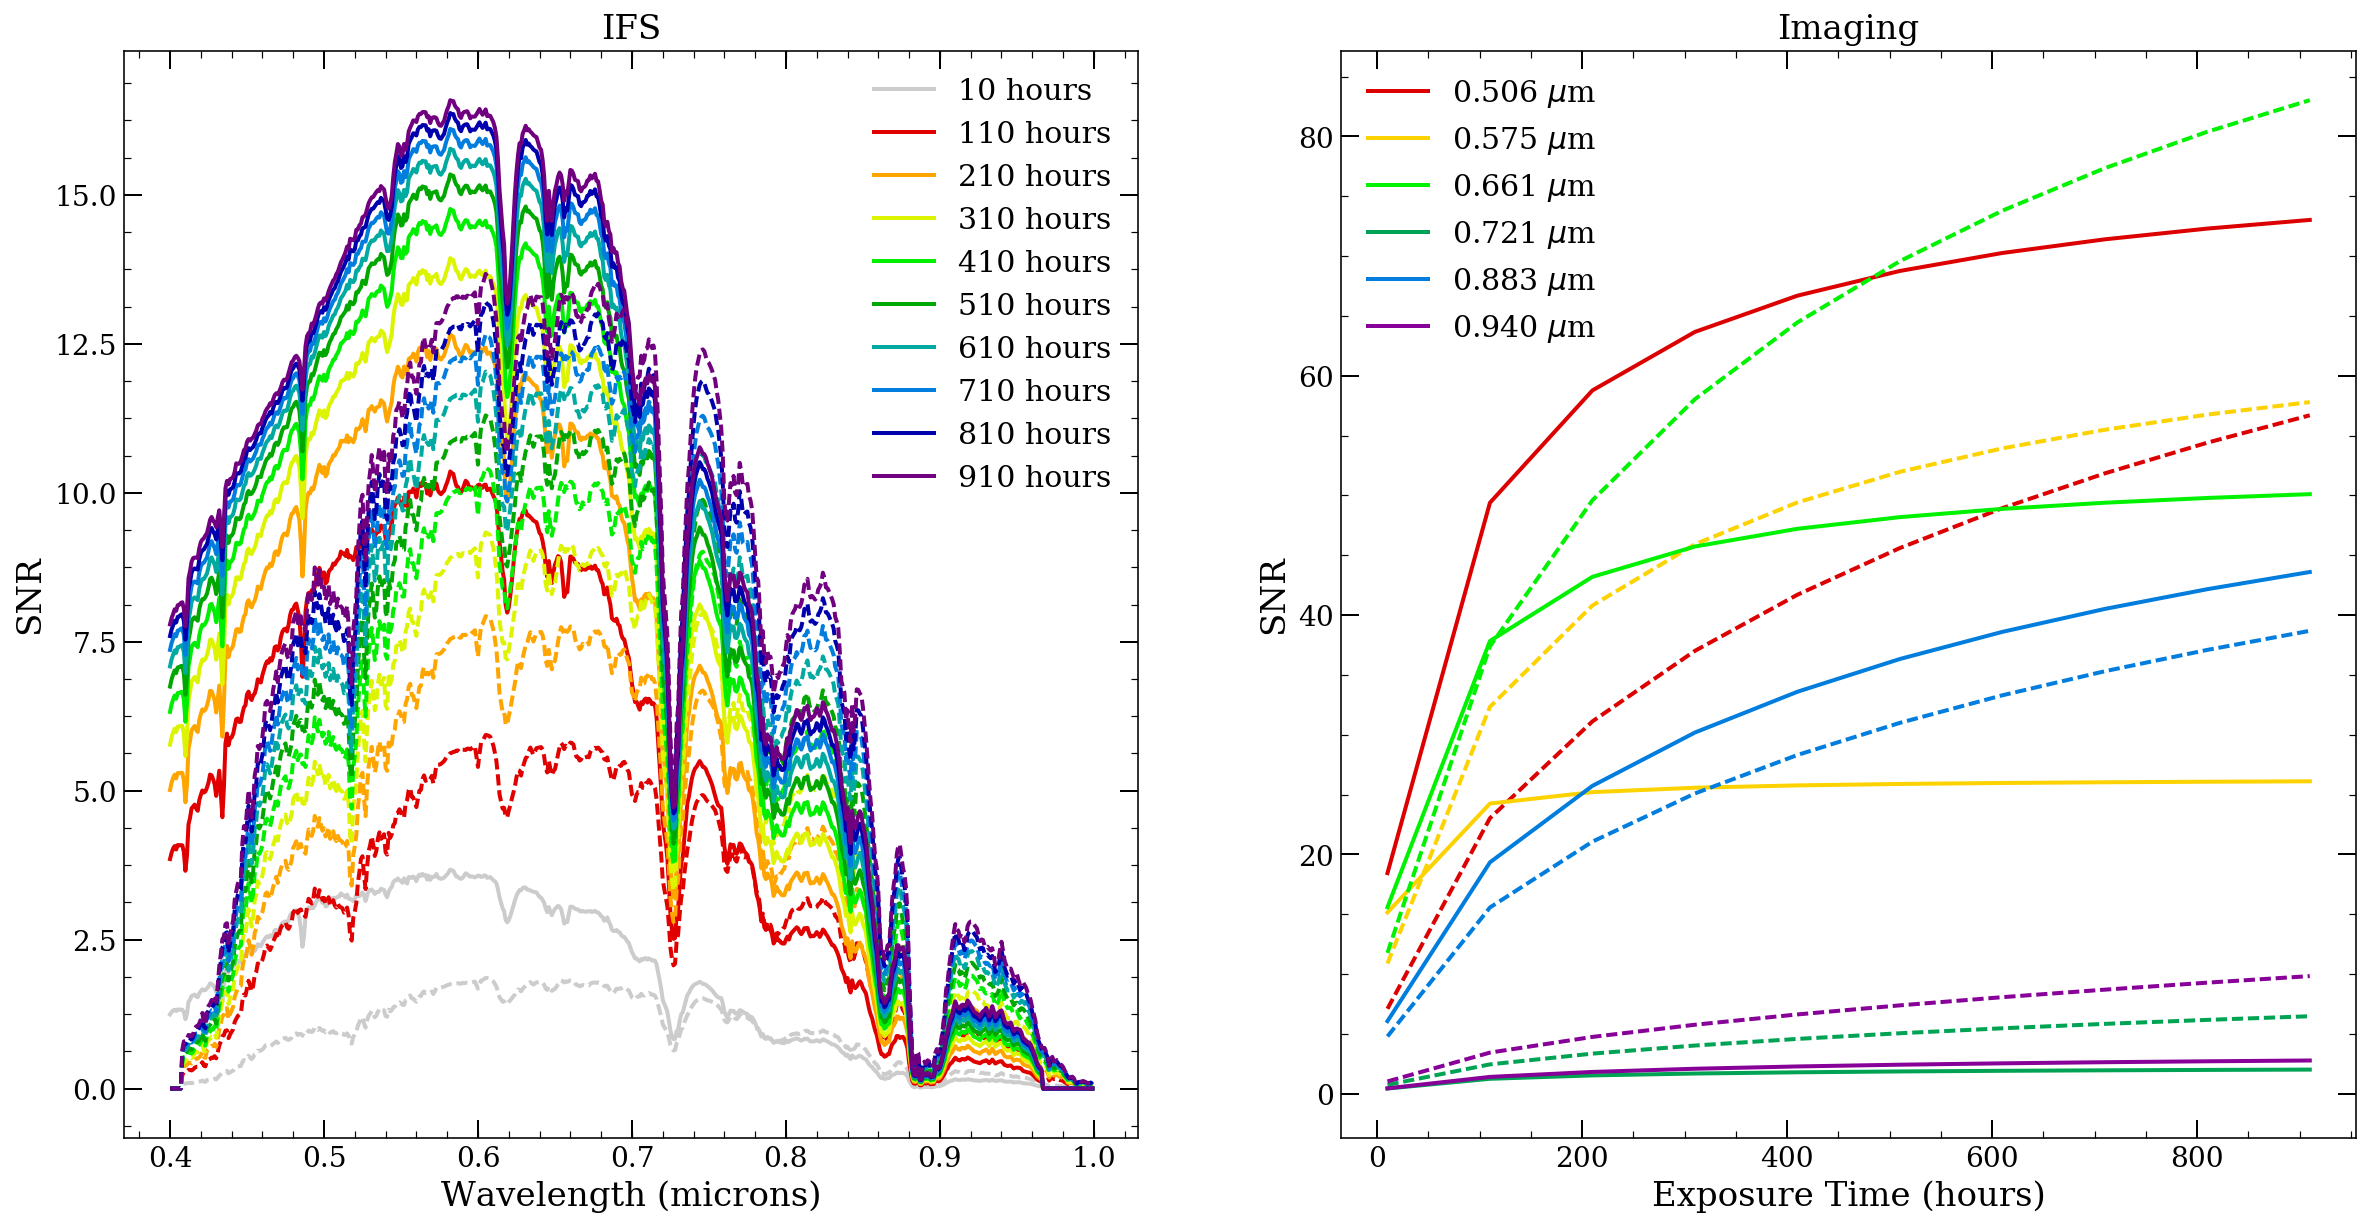

In [79]:
# for IFS

HD_h.update(mu.cbe_spc_pars)
upsAnd_d.update(mu.cbe_spc_pars)

texp_list = np.arange(10.0,1000.0,100.0)*60.0*60.0  # should be in seconds
start = 0.0
stop = 0.95
number_of_lines= len(texp_list)
cm_subsection = np.linspace(start, stop, number_of_lines) 
color_list = [ mu.CMAP2(x) for x in cm_subsection ]

plt.figure(figsize=(20.0, 10.0))
ax=plt.subplot(1,2,1)
wavelengths = np.arange(0.4,1.0,0.001)             # should be in microns
for texp,col in zip(texp_list,color_list):
    upsAnd_snr = snr_ifs.calc_snr(texp,wavelengths,upsAnd_d)
    HD_h_snr = snr_ifs.calc_snr(texp,wavelengths,HD_h)
    plt.plot(wavelengths,upsAnd_snr,color=col,label='%.0f hours'%(texp/60.0/60.0))
    plt.plot(wavelengths,HD_h_snr,color=col,linestyle='--')

plt.legend(frameon=False,fontsize=15)    

# for imaging

HD_h.update(mu.cbe_hlc_pars)
upsAnd_d.update(mu.cbe_hlc_pars)   

centers = [0.506,0.575,0.661,0.883,0.721,0.940] 
widths = [10.3,10.1,10.0,5.2,5.0,6.4]
imagingbands = [ mu.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0), 50000) for bandcenter,width in zip(centers,widths)]

plt.xlabel('Wavelength (microns)',fontsize=17)
plt.ylabel('SNR',fontsize=17)
ax.set_title('IFS',fontsize=17)

ax = plt.subplot(1,2,2)

centers = [0.506,0.575,0.661,0.721,0.883,0.940]  ### the 0.575 and 0.883 imaging bands will be fully tested
start = 0.1
stop = 0.9
number_of_lines= len(centers)
cm_subsection = np.linspace(start, stop, number_of_lines) 
color_list = [ mu.CMAP2(x) for x in cm_subsection ]

for wavelengths,cols,center in zip(imagingbands, color_list,centers):
    snrs=snr_im.calc_snr(texp_list,wavelengths,HD_h)
    plt.plot(texp_list/60.0/60.0,snrs,linestyle='--',color=cols)
    snrs=snr_im.calc_snr(texp_list,wavelengths,upsAnd_d)
    plt.plot(texp_list/60.0/60.0,snrs,color=cols,label='%.3f $\mu$m'%center)    
plt.legend(frameon=False,fontsize=15)     
plt.xlabel('Exposure Time (hours)',fontsize=17)
plt.ylabel('SNR',fontsize=17)
ax.set_title('Imaging',fontsize=17)

Look at maximum possible SNR

/Applications/anaconda/envs/ast542/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/Applications/anaconda/envs/ast542/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/Applications/anaconda/envs/ast542/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
/Applications/anaconda/envs/ast542/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


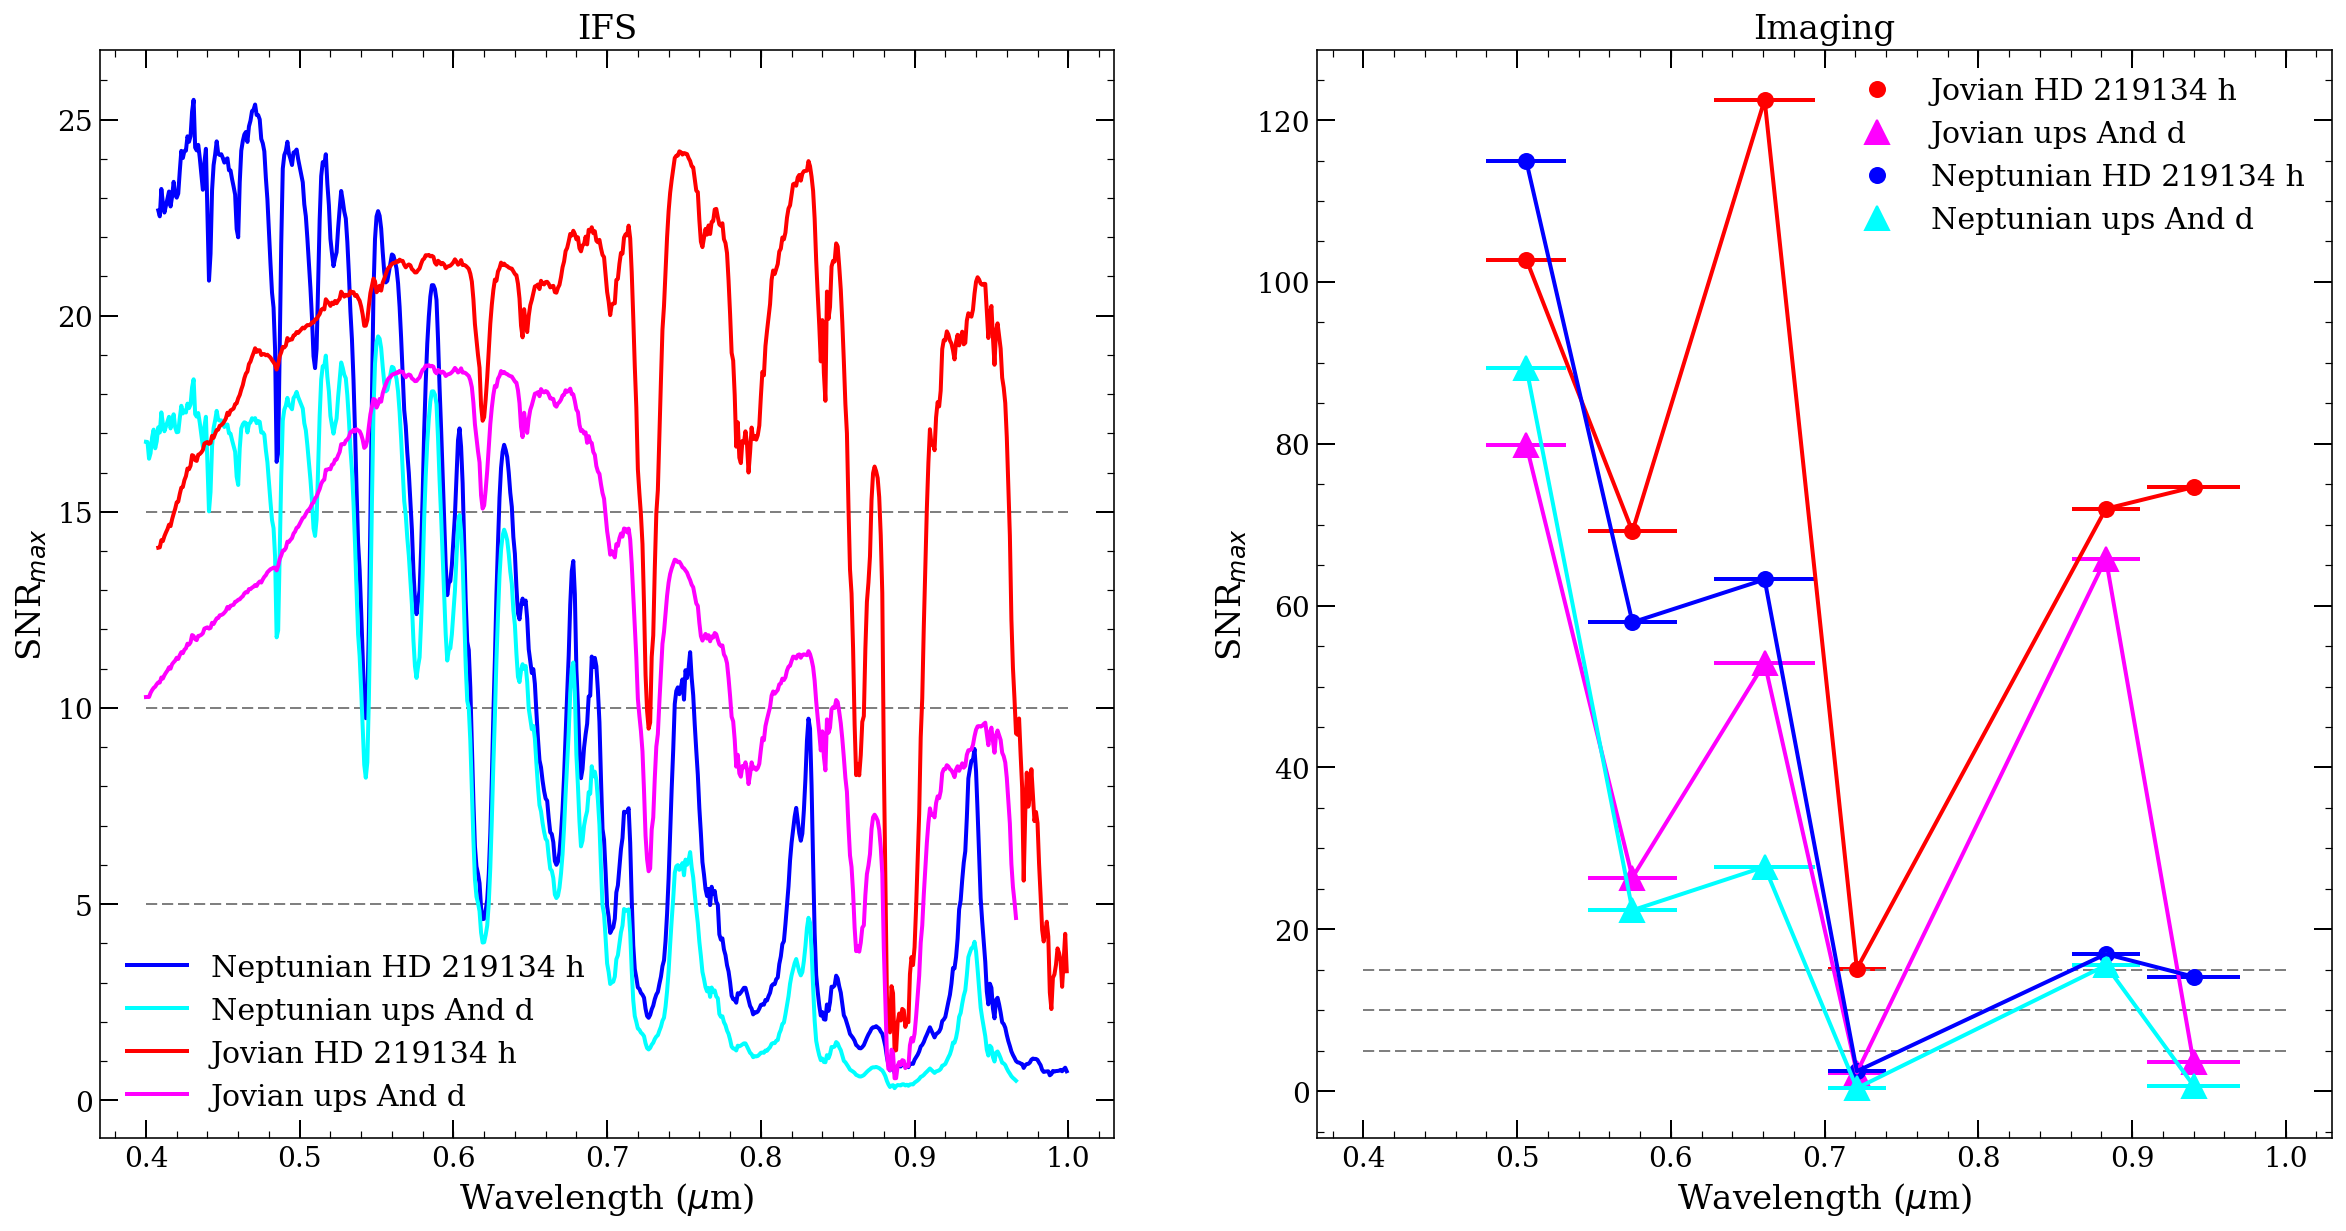

In [80]:
HD_h.update(mu.cbe_spc_pars)
upsAnd_d.update(mu.cbe_spc_pars)

plt.figure(figsize=(20.0, 10.0))
ax=plt.subplot(1,2,1)
wavelengths = np.arange(0.4,1.0,0.001)
HD_h.update({'chromo':0.0,'meth':0.0})
HD_h.update({'Ag':hpm.juneper_Agfunc(HD_h['chromo'],HD_h['meth'])}) 
rp, rz, rs, rd, rcic, rr, rn = snr_ifs.calc_rates(wavelengths, HD_h)
neptune_max_HD_h = rp/(HD_h['fpp']*rs)
HD_h.update({'chromo':1.0,'meth':1.0})
HD_h.update({'Ag':hpm.juneper_Agfunc(HD_h['chromo'],HD_h['meth'])}) 
rp, rz, rs, rd, rcic, rr, rn = snr_ifs.calc_rates(wavelengths, HD_h)
jupiter_max_HD_h = rp/(HD_h['fpp']*rs)

upsAnd_d.update({'chromo':0.0,'meth':0.0})
upsAnd_d.update({'Ag':hpm.juneper_Agfunc(upsAnd_d['chromo'],upsAnd_d['meth'])}) 
rp, rz, rs, rd, rcic, rr, rn = snr_ifs.calc_rates(wavelengths, upsAnd_d)
neptune_max_upsAnd = rp/(upsAnd_d['fpp']*rs)
upsAnd_d.update({'chromo':1.0,'meth':1.0})
upsAnd_d.update({'Ag':hpm.juneper_Agfunc(upsAnd_d['chromo'],upsAnd_d['meth'])})
rp, rz, rs, rd, rcic, rr, rn = snr_ifs.calc_rates(wavelengths, upsAnd_d)
jupiter_max_upsAnd = rp/(upsAnd_d['fpp']*rs)

plt.plot(wavelengths,neptune_max_HD_h,color='blue',label='Neptunian HD 219134 h')
plt.plot(wavelengths,neptune_max_upsAnd,color='cyan',label='Neptunian ups And d')
plt.plot(wavelengths,jupiter_max_HD_h,color='red',label='Jovian HD 219134 h')
plt.plot(wavelengths,jupiter_max_upsAnd,color='magenta',label='Jovian ups And d')
plt.hlines([5.0,10.0,15.0],0.4,1.0,linestyle='--',linewidth=1,color='grey')
plt.legend(frameon=False,fontsize=15)
ax.set_title('IFS',fontsize=17)
plt.ylabel('SNR$_{max}$',fontsize=17)
plt.xlabel('Wavelength ($\mu$m)',fontsize=17)


ax = plt.subplot(1,2,2)
HD_h.update(mu.cbe_hlc_pars)
upsAnd_d.update(mu.cbe_hlc_pars) 

HD_h_rates,upsAnd_d_rates = [],[]
for wavelengths in imagingbands:
    HD_h_rates.append(snr_im.calc_rates(wavelengths, HD_h))
    upsAnd_d_rates.append(snr_im.calc_rates(wavelengths, upsAnd_d))
HD_h_rates,upsAnd_d_rates=np.array(HD_h_rates),np.array(upsAnd_d_rates)   
HD_h_snrmax = HD_h_rates[:,0]/(HD_h['fpp']*HD_h_rates[:,2])
upsAnd_d_snrmax = upsAnd_d_rates[:,0]/(upsAnd_d['fpp']*upsAnd_d_rates[:,2])
plt.plot(centers,HD_h_snrmax,'r.',markersize=15,label='Jovian HD 219134 h')
plt.errorbar(centers,HD_h_snrmax,xerr=np.array(centers)*np.array(widths)/200.0,color='red')
plt.plot(centers,upsAnd_d_snrmax,'^',color='magenta',markersize=12,label='Jovian ups And d')
plt.errorbar(centers,upsAnd_d_snrmax,xerr=np.array(centers)*np.array(widths)/200.0,color='magenta')

HD_h.update({'chromo':0.0,'meth':0.0})
HD_h.update({'Ag':hpm.juneper_Agfunc(HD_h['chromo'],HD_h['meth'])}) 
upsAnd_d.update({'chromo':0.0,'meth':0.0})
upsAnd_d.update({'Ag':hpm.juneper_Agfunc(upsAnd_d['chromo'],upsAnd_d['meth'])}) 
HD_h_rates,upsAnd_d_rates = [],[]
for wavelengths in imagingbands:
    HD_h_rates.append(snr_im.calc_rates(wavelengths, HD_h))
    upsAnd_d_rates.append(snr_im.calc_rates(wavelengths, upsAnd_d))
HD_h_rates,upsAnd_d_rates=np.array(HD_h_rates),np.array(upsAnd_d_rates)   
HD_h_snrmax = HD_h_rates[:,0]/(HD_h['fpp']*HD_h_rates[:,2])
upsAnd_d_snrmax = upsAnd_d_rates[:,0]/(upsAnd_d['fpp']*upsAnd_d_rates[:,2])
plt.plot(centers,HD_h_snrmax,'.',color='b',markersize=15,label='Neptunian HD 219134 h')
plt.errorbar(centers,HD_h_snrmax,xerr=np.array(centers)*np.array(widths)/200.0,color='blue')
plt.plot(centers,upsAnd_d_snrmax,'^',color='cyan',markersize=12,label='Neptunian ups And d')
plt.errorbar(centers,upsAnd_d_snrmax,xerr=np.array(centers)*np.array(widths)/200.0,color='cyan')

plt.hlines([5.0,10.0,15.0],0.4,1.0,linestyle='--',linewidth=1,color='grey')
plt.legend(frameon=False,fontsize=15)
ax.set_title('Imaging',fontsize=17)
plt.ylabel('SNR$_{max}$',fontsize=17)
plt.xlabel('Wavelength ($\mu$m)',fontsize=17)





Look at exposure times necessary to reach SNR = 15

/Users/blacy/EGPSemesterProject/GitHubFiles/direct-imaging-sims/WFIRST_SIM/orbit_class.py:87: RuntimeWarning: invalid value encountered in arcsin
  ta =  np.arcsin(np.cos(alpha)/np.sin(self.inc)) - self.argperi
/Users/blacy/EGPSemesterProject/GitHubFiles/direct-imaging-sims/WFIRST_SIM/ifs_noise_model.py:137: RuntimeWarning: divide by zero encountered in true_divide
  return SNR**2.0*rn / (rp**2.0 - (SNR*params['fpp']*rs)**2.0)


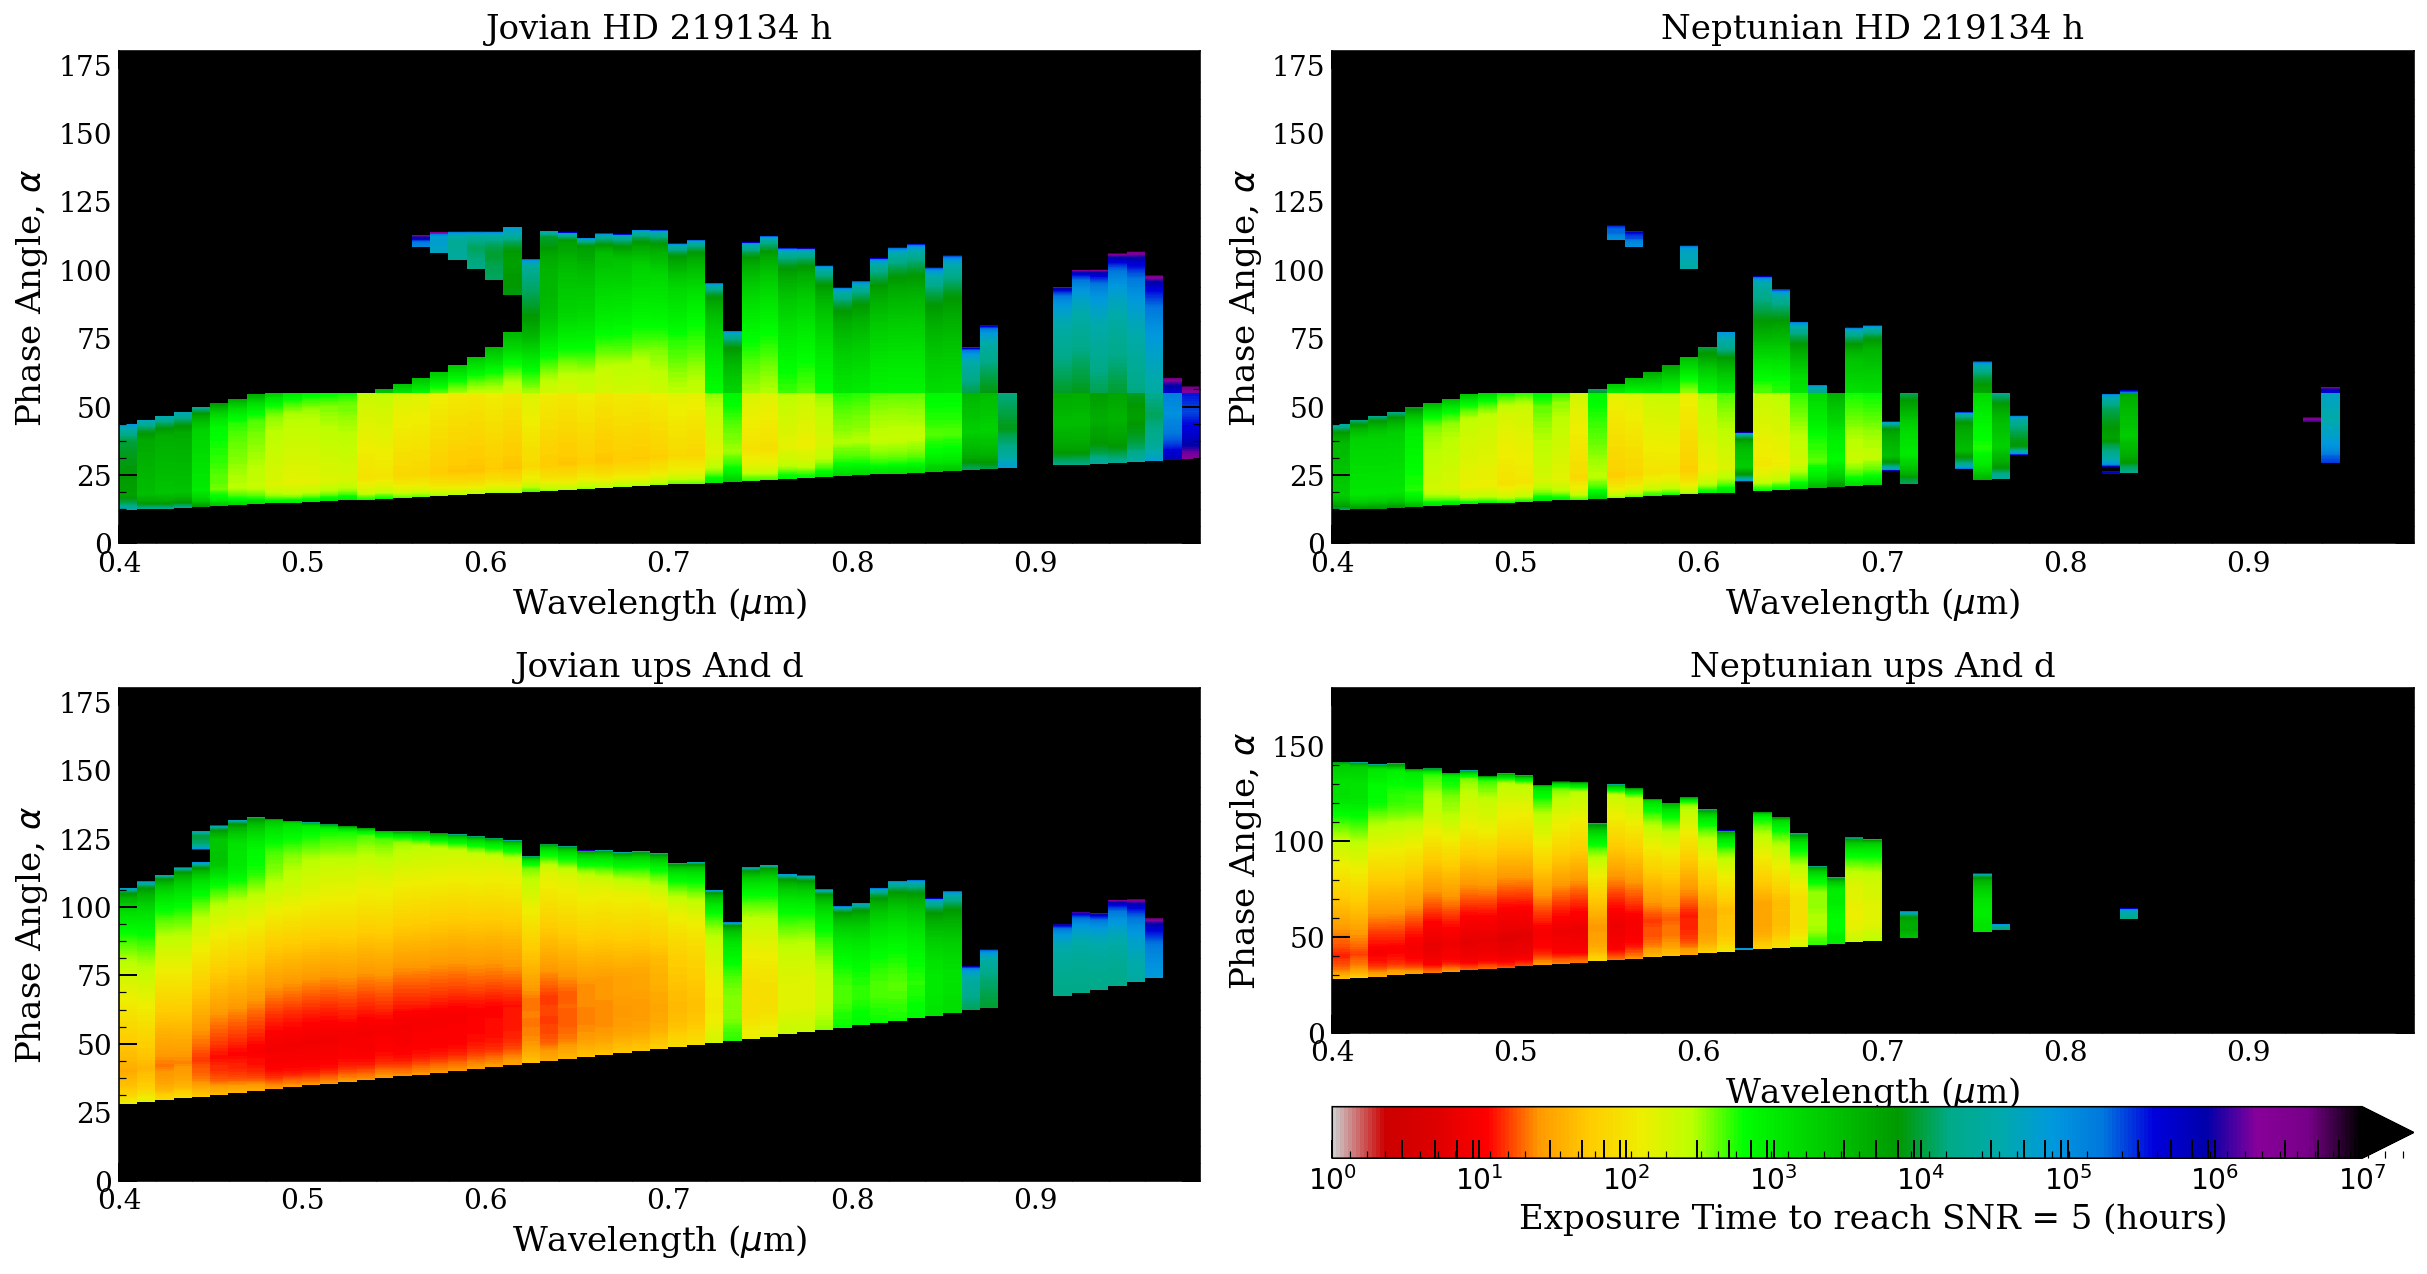

In [72]:
HD_h.update(mu.cbe_spc_pars)
upsAnd_d.update(mu.cbe_spc_pars)
#WAVELENGTH vs. ALPHA SNR of 5 exposuretimes
wavelengths = np.arange(0.4,1.0,0.01)
HD_h.update({'chromo':1.0,'meth':1.0})
HD_h.update({'Ag':hpm.juneper_Agfunc(HD_h['chromo'],HD_h['meth'])}) 
plt.figure(figsize=(17.0, 9.0))
ax=plt.subplot(2,2,1)
alpha_tsnr_plot(HD_h,HD_h_orbit,wavelengths,5.0,cbar=False)
ax.set_title('Jovian HD 219134 h',fontsize=17)

HD_h.update({'chromo':0.0,'meth':0.0})
HD_h.update({'Ag':hpm.juneper_Agfunc(HD_h['chromo'],HD_h['meth'])}) 
ax=plt.subplot(2,2,2)
alpha_tsnr_plot(HD_h,HD_h_orbit,wavelengths,5.0,cbar=False)
ax.set_title('Neptunian HD 219134 h',fontsize=17)

upsAnd_d.update({'chromo':1.0,'meth':1.0})
upsAnd_d.update({'Ag':hpm.juneper_Agfunc(upsAnd_d['chromo'],upsAnd_d['meth'])}) 
ax=plt.subplot(2,2,3)
alpha_tsnr_plot(upsAnd_d,upsAnd_d_orbit,wavelengths,5.0,cbar=False)
ax.set_title('Jovian ups And d',fontsize=17)

upsAnd_d.update({'chromo':0.0,'meth':0.0})
upsAnd_d.update({'Ag':hpm.juneper_Agfunc(upsAnd_d['chromo'],upsAnd_d['meth'])}) 
ax=plt.subplot(2,2,4)
alpha_tsnr_plot(upsAnd_d,upsAnd_d_orbit,wavelengths,5.0,cbar=True)
ax.set_title('Neptunian ups And d',fontsize=17)

plt.tight_layout()
plt.show()

/Users/blacy/EGPSemesterProject/GitHubFiles/direct-imaging-sims/WFIRST_SIM/ifs_noise_model.py:137: RuntimeWarning: divide by zero encountered in true_divide
  return SNR**2.0*rn / (rp**2.0 - (SNR*params['fpp']*rs)**2.0)


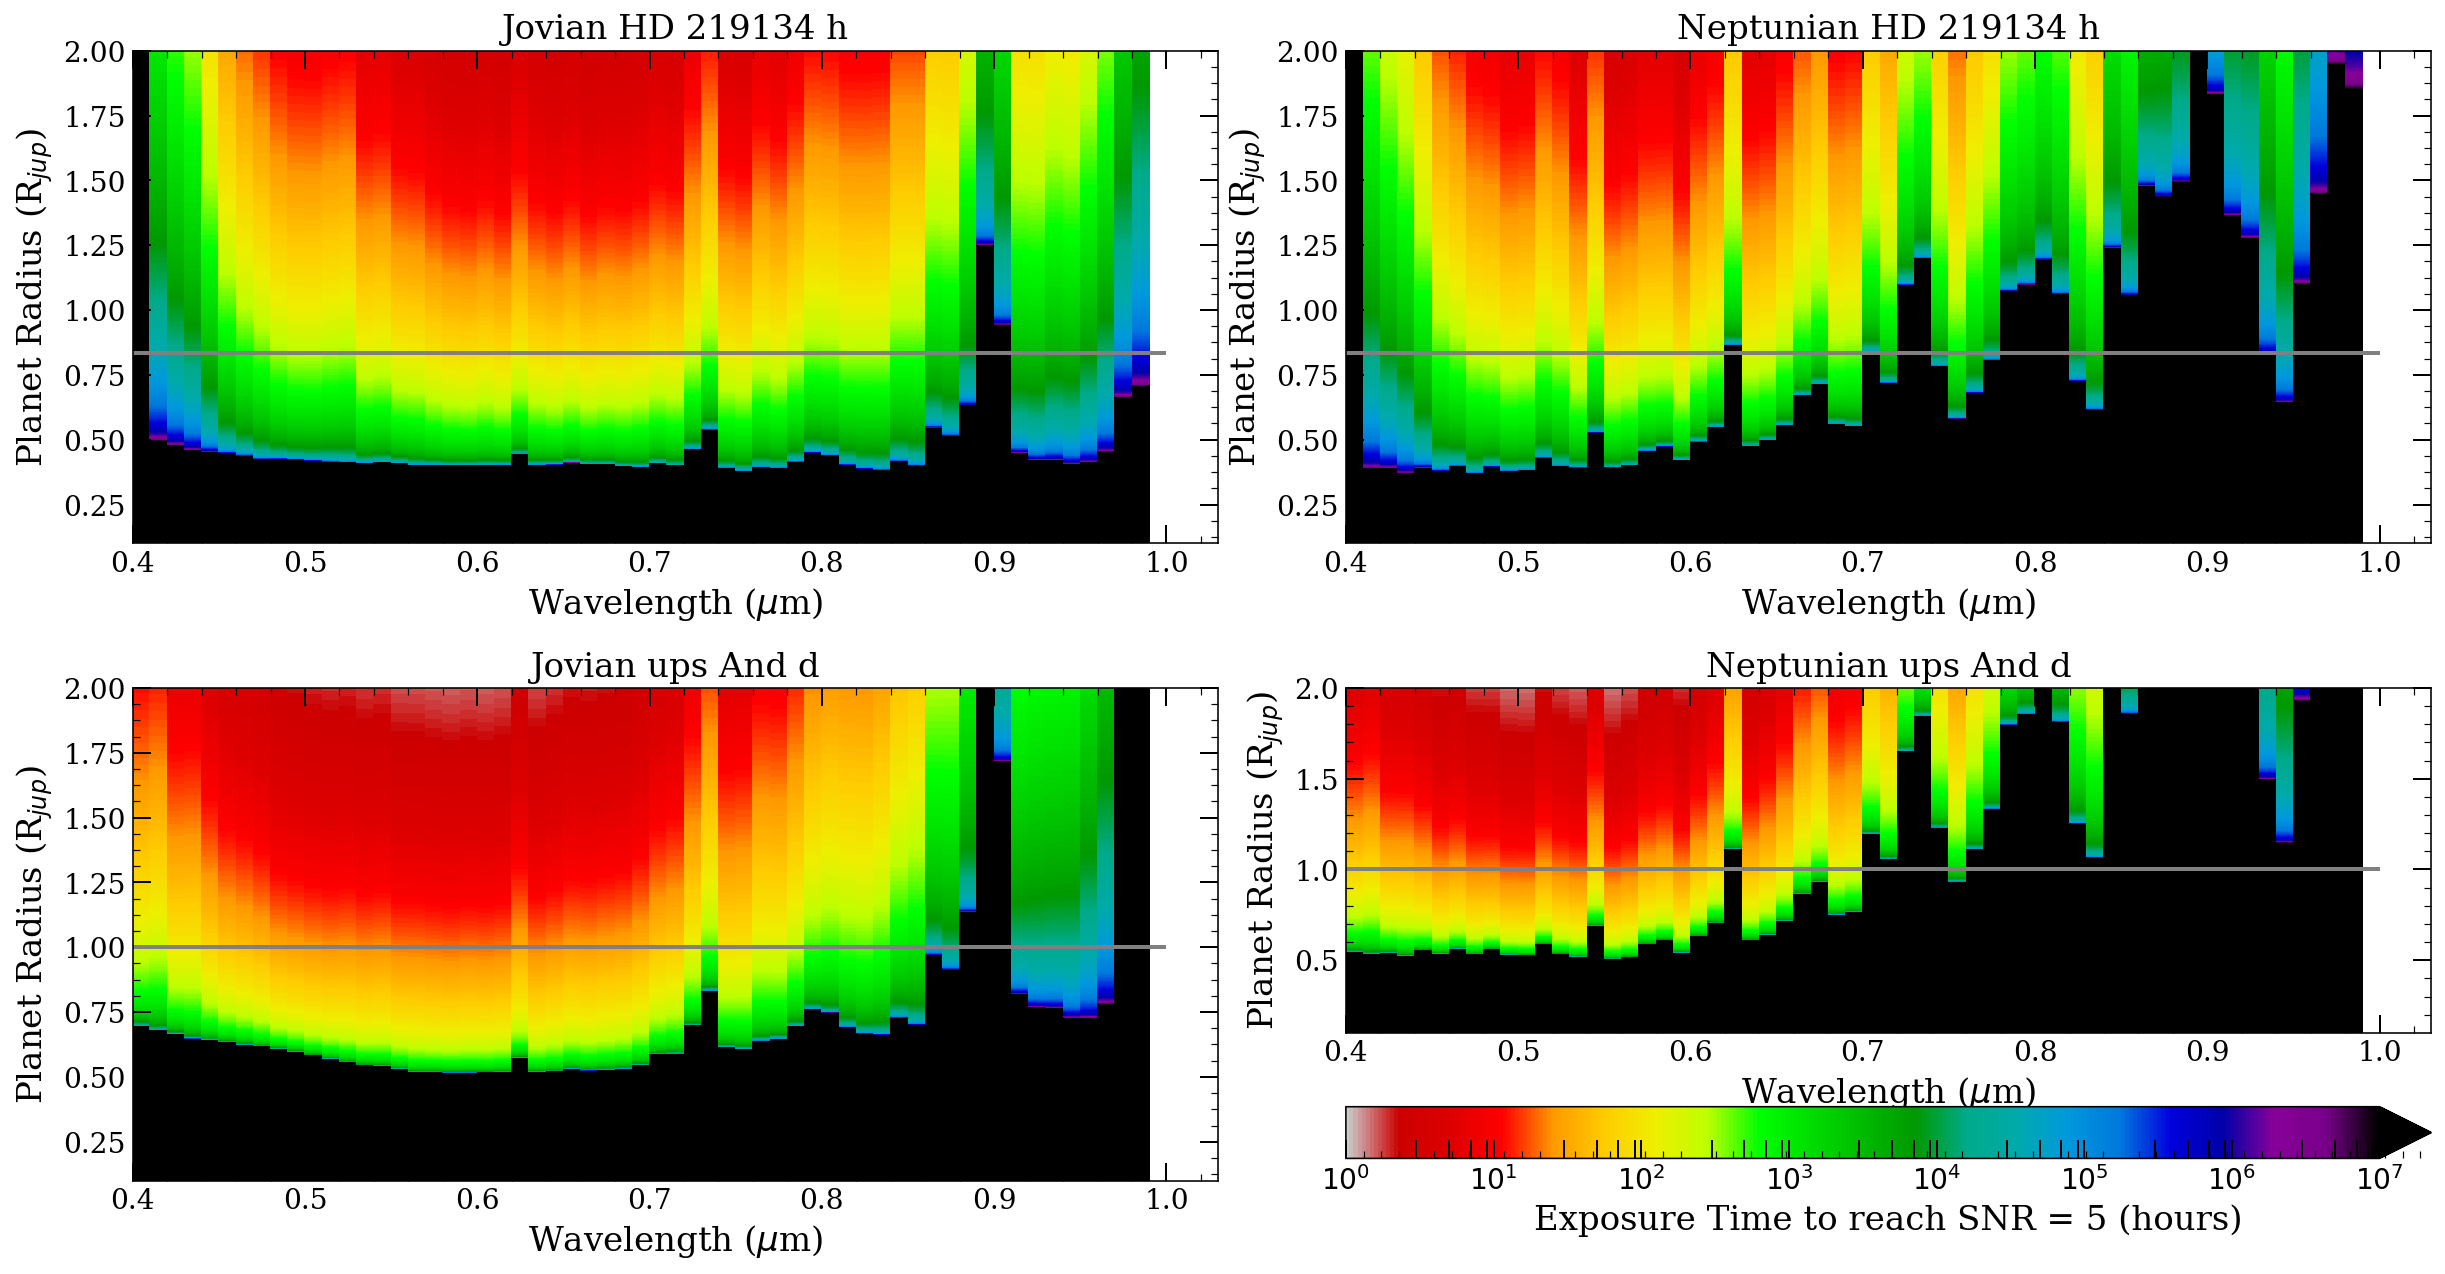

In [83]:
HD_h.update(mu.cbe_spc_pars)
upsAnd_d.update(mu.cbe_spc_pars)
# WAVELENGTH vs Rp
wavelengths = np.arange(0.4,1.0,0.01)
HD_h.update({'chromo':1.0,'meth':1.0})
HD_h.update({'Ag':hpm.juneper_Agfunc(HD_h['chromo'],HD_h['meth'])}) 
plt.figure(figsize=(17.0, 9.0))
ax=plt.subplot(2,2,1)
rp_tsnr_plot(HD_h,wavelengths,5.0,cbar=False)
plt.hlines(0.83294,0.4,1.0,color='grey')
ax.set_title('Jovian HD 219134 h',fontsize=17)

HD_h.update({'chromo':0.0,'meth':0.0})
HD_h.update({'Ag':hpm.juneper_Agfunc(HD_h['chromo'],HD_h['meth'])}) 
ax=plt.subplot(2,2,2)
rp_tsnr_plot(HD_h,wavelengths,5.0,cbar=False)
plt.hlines(0.83294,0.4,1.0,color='grey')
ax.set_title('Neptunian HD 219134 h',fontsize=17)

upsAnd_d.update({'chromo':1.0,'meth':1.0})
upsAnd_d.update({'Ag':hpm.juneper_Agfunc(upsAnd_d['chromo'],upsAnd_d['meth'])}) 
ax=plt.subplot(2,2,3)
rp_tsnr_plot(upsAnd_d,wavelengths,5.0,cbar=False)
plt.hlines(1.0,0.4,1.0,color='grey')
ax.set_title('Jovian ups And d',fontsize=17)

upsAnd_d.update({'chromo':0.0,'meth':0.0})
upsAnd_d.update({'Ag':hpm.juneper_Agfunc(upsAnd_d['chromo'],upsAnd_d['meth'])}) 
ax=plt.subplot(2,2,4)
rp_tsnr_plot(upsAnd_d,wavelengths,5.0,cbar=True)
plt.hlines(1.0,0.4,1.0,color='grey')
ax.set_title('Neptunian ups And d',fontsize=17)

plt.tight_layout()